# Sarter Notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading Data

In [2]:
# read train data
df_orders = pd.read_csv("orders.csv", sep=";")
df_products = pd.read_csv("product_attributes.csv", sep=",")
df_dists = pd.read_csv("cities_data.csv", sep=";")

# read test data
df_test = pd.read_csv("test.csv", sep=";")

# Clean the data

In [60]:
df_orders["origin_port"] = df_orders["origin_port"].replace(["ATHENAS"], "Athens")
df_orders["origin_port"] = df_orders["origin_port"].replace(["BCN"], "Barcelona")
df_orders["late_order"] = df_orders["late_order"].astype(int)

# Analaize the data

In [61]:
df_orders.head()


,order_id,origin_port,3pl,customs_procedures,logistic_hub,customer,product_id,units,late_order
0,366c7a3d298f,Rotterdam,v_002,DTP,Venlo,Marseille,1692723,583,1
1,45f906331e10,Rotterdam,v_004,CRF,Rome,Marseille,1644308,459,0
2,ac84a6e4af0f,Athens,v_002,CRF,Venlo,Paris,1684170,464,1
3,f5e98cb29790,Rotterdam,v_004,CRF,Lille,Milan,1620510,678,0
4,a9e7c9bee35b,Barcelona,v_002,CRF,Venlo,Berlin,1699372,353,0


In [62]:
counts1 = df_orders["late_order"].groupby(df_orders["3pl"]).value_counts()
# For every 3pl, print the percentage of late orders
for i in range(1, 5):
    print(f"v_00{i}", ":", counts1[f"v_00{i}"][0]/(counts1[f"v_00{i}"][0]+counts1[f"v_00{i}"][1]))

v_001 : 0.6179014667168108
v_002 : 0.8005533611227406
v_003 : 0.7497475840184624
v_004 : 0.7430507101217673


In [63]:
counts2 = df_orders["late_order"].groupby(df_orders["customs_procedures"]).value_counts()
print(counts2)
# For every custom_procedures, print the percentage of late orders
for name in ["CRF", "DTD", "DTP"]:
   print(name, ":", counts2[name][0]/(counts2[name][0]+counts2[name][1]))

customs_procedures  late_order
CRF                 0             41274
                    1             10203
DTD                 0             32548
                    1             10936
DTP                 0             13298
                    1              6017
Name: late_order, dtype: int64
CRF : 0.801794976397226
DTD : 0.7485051973139546
DTP : 0.6884804556044525


In [64]:
counts3 = df_orders["customs_procedures"].groupby(df_orders["3pl"]).value_counts()
print(counts3)

3pl    customs_procedures
v_001  CRF                    3686
       DTD                    2960
       DTP                    1331
v_002  CRF                   24595
       DTD                   21035
       DTP                    9307
v_003  CRF                    3103
       DTD                    2658
       DTP                    1172
v_004  CRF                   20093
       DTD                   16831
       DTP                    7505
Name: customs_procedures, dtype: int64


In [ ]:
df_orders.describe()

# ML

### Split the data

In [205]:
import sklearn as sk

  origin_port    3pl customs_procedures logistic_hub   customer  units
0   Rotterdam  v_002                DTP        Venlo  Marseille    583
1   Rotterdam  v_004                CRF         Rome  Marseille    459
2      Athens  v_002                CRF        Venlo      Paris    464
3   Rotterdam  v_004                CRF        Lille      Milan    678
4   Barcelona  v_002                CRF        Venlo     Berlin    353
[1 0 0 ... 0 0 0]


### SVM

In [259]:
X = df_orders.drop(['late_order', 'order_id', 'product_id', 'units'], axis=1)
y = np.array(df_orders['late_order'])

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enc = pd.get_dummies(X_train, columns=["origin_port", "3pl", "customs_procedures", "logistic_hub", "customer"])
X_test_enc = pd.get_dummies(X_test, columns=["origin_port", "3pl", "customs_procedures", "logistic_hub", "customer"])

In [258]:
from sklearn.kernel_approximation import Nystroem
import sklearn.svm as svm
feature_map_nystroem = Nystroem(gamma=0.01,
                                random_state=42,
                                 n_components=X_train_enc.shape[0])
linmodel = svm.LinearSVC()
linmodel.fit(X_train_enc, y_train)
y_pred = linmodel.predict(X_test_enc)
accuracy = sk.metrics.accuracy_score(y_test, y_pred)

### Decision trees

In [260]:
X = df_orders.drop(['late_order', 'order_id', 'product_id'], axis=1)
y = np.array(df_orders['late_order'])

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enc = pd.get_dummies(X_train, columns=["origin_port", "3pl", "customs_procedures", "logistic_hub", "customer"])
X_test_enc = pd.get_dummies(X_test, columns=["origin_port", "3pl", "customs_procedures", "logistic_hub", "customer"])

In [262]:
from sklearn.tree import DecisionTreeClassifier
xval = [i for i in range(2, 18)]
yval = [None for _ in range(2, 18)]
for i in range(2, 18):
    modelt = DecisionTreeClassifier(criterion="entropy", max_depth=i)
    modelt.fit(X_train_enc, y_train)
    y_pred = modelt.predict(X_test_enc)
    yval[i-2] = sk.metrics.accuracy_score(y_pred, y_test)


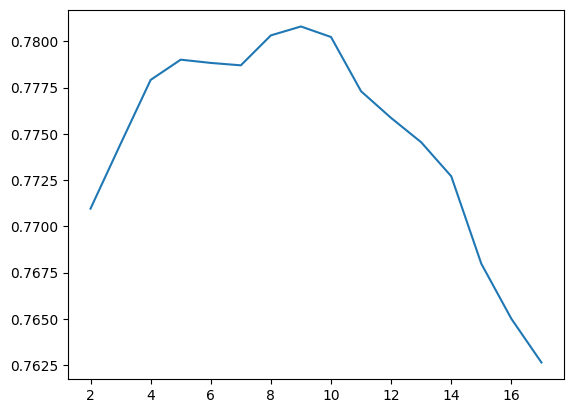

In [263]:
plt.plot(xval,yval)

In [ ]:
from sklearn.tree import plot_tree
plot_tree(modelt)

In [221]:
accuracy2 = sk.metrics.accuracy_score(y_pred, y_test)
print(accuracy2)

0.7804077703885194


## Save Solution
> **Note:** Submited probabilities must be for the **True** cases.

In [ ]:
submission = pd.DataFrame({"order_id": X_test.order_id, "late_order": pred_proba[:,1]})
submission.to_csv("submission_kaggle.csv", index=False)